# Task: Software Defect Prediction via Convolutional Neural Network
## Mô tả bài toán
Dựa vào paper IEEE 2017 - DP-CNN đề xuất 1 phuơng pháp mới, DP-CNN (Defect Prediction via Convolutional Neural Network) là một phương pháp dự đoán lỗi phần mềm bằng cách kết hợp học sâu với các đặc trưng truyền thống. Thay vì chỉ dựa vào các đặc trưng thủ công như độ phức tạp mã nguồn, DP-CNN tự động học đặc trưng ngữ nghĩa và cấu trúc từ cây Cú pháp Trừu tượng (AST) bằng CNN, sau đó kết hợp với các đặc trưng truyền thống để cải thiện độ chính xác.
## Phương pháp đề xuất
1️⃣ Phân tích mã nguồn thành cây AST, trích xuất token quan trọng.

2️⃣ Mã hóa token thành vector số bằng kỹ thuật word embedding.

3️⃣ Sử dụng CNN để học đặc trưng ngữ nghĩa và cấu trúc từ mã nguồn.

4️⃣ Kết hợp với đặc trưng truyền thống để tối ưu dự đoán.

5️⃣ Huấn luyện mô hình và phân loại file là "có lỗi" hoặc "không lỗi".

# 1. Phân tích dữ liệu

- Dự kiến: Lấy tập Synapse-1.1 để trainning và tập Synapse-1.2 để test1
- Tải bộ source code của bộ Synapse-1.1 và Synapse-1.2 từ archive.apache.org.
- Đọc dữ liệu csv chứa thông tin về các đặc trưng truyền thống về phần mềm và label cho biết code lỗi hay không
- Lọc chỉ lấy những file source code có trong file csv đã phân tích

## Tải bộ source code trên archive.appache.org

In [ ]:
!wget https://archive.apache.org/dist/synapse/1.0/synapse-1.0-src.tar.gz
!tar -xvzf synapse-1.0-src.tar.gz

!wget https://archive.apache.org/dist/synapse/1.1/synapse-1.1-src.tar.gz
!tar -xvzf synapse-1.1-src.tar.gz

!wget https://archive.apache.org/dist/synapse/1.2/synapse-1.2-src.tar.gz
!tar -xvzf synapse-1.2-src.tar.gz


--2025-03-22 09:00:40--  https://archive.apache.org/dist/synapse/1.0/synapse-1.0-src.tar.gz
Resolving archive.apache.org (archive.apache.org)... 65.108.204.189, 2a01:4f9:1a:a084::2
Connecting to archive.apache.org (archive.apache.org)|65.108.204.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382391 (373K) [application/x-gzip]
Saving to: ‘synapse-1.0-src.tar.gz’

synapse-1.0-src.tar 100%[===================>] 373.43K   317KB/s    in 1.2s    

2025-03-22 09:00:43 (317 KB/s) - ‘synapse-1.0-src.tar.gz’ saved [382391/382391]

synapse-1.0-src/modules/core/
synapse-1.0-src/modules/core/logs/
synapse-1.0-src/modules/core/src/
synapse-1.0-src/modules/core/src/main/
synapse-1.0-src/modules/core/src/main/java/
synapse-1.0-src/modules/core/src/main/java/org/
synapse-1.0-src/modules/core/src/main/java/org/apache/
synapse-1.0-src/modules/core/src/main/java/org/apache/synapse/
synapse-1.0-src/modules/core/src/main/java/org/apache/synapse/config/
synapse-1.0-src/modules/

## Tải bộ dữ liệu Apache chứa các đặc trưng truyền thống

In [ ]:
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

synapse10_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/synapse-1.0.csv"
synapse11_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/synapse-1.1.csv"
synapse12_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/synapse-1.2.csv"
synapse10_csv = pd.read_csv(synapse10_path)
synapse11_csv = pd.read_csv(synapse11_path)
synapse12_csv = pd.read_csv(synapse12_path)


Mounted at /content/drive


# 2. Tiền xử lí dữ liệu

## Ghép các bộ bộ dữ liệu

In [ ]:
# Ghép dữ liệu (không thêm cột version)
synapse_all_csv = pd.concat([synapse10_csv, synapse11_csv, synapse12_csv], ignore_index=True)

# Lưu file
output_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/synapse-all.csv"
synapse_all_csv.to_csv(output_path, index=False)
print(len(synapse_all_csv))
print("File đã được ghép và lưu tại:", output_path)


635
File đã được ghép và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/synapse-all.csv


In [ ]:
synapse10_src = "synapse-1.0-src/modules/core/src/main/java/org/apache/synapse"
synapse11_src = "synapse-1.1-src/modules/core/src/main/java/org/apache/synapse"
synapse12_src = "synapse-1.2-src/modules/core/src/main/java/org/apache/synapse"


In [ ]:
# Hàm lấy tất cả file Java trong thư mục mã nguồn (bao gồm tất cả thư mục con trong tools/)
def get_all_java_files(directory):
    """Lấy tất cả file Java trong thư mục tools/ """
    java_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".java"):
                java_files.append(os.path.join(root, file))
    return java_files

In [ ]:
synapse_all_src = (
    get_all_java_files(synapse10_src)
    + get_all_java_files(synapse11_src)
    + get_all_java_files(synapse12_src)
)

## Chuẩn hoá dữ liệu giữa 2 dạng dữ liệu và loại bỏ

### Chuẩn hoá giữa 2 dạng dữ liệu (csv và file source code)

In [ ]:
# Chuẩn hóa tên file từ CSV để phù hợp với thư mục tools/
def convert_csv_name_to_java_filename(csv_name):
    """
    Chuyển:
    'org.apache.synapse.config.xml.ProxyServiceFactory' → 'config/xml/ProxyServiceFactory.java'

    Cách làm:
    - Tìm 'synapse.' trong đường dẫn, lấy phần sau nó làm thư mục gốc.
    - Nếu không có 'synapse.', giữ nguyên tên và thêm .java
    """
    parts = csv_name.split('.')
    if 'synapse' in parts:
        index = parts.index('synapse') + 1  # Lấy phần sau 'synapse'
        return "/".join(parts[index:]) + ".java"
    return csv_name.replace('.', '/') + ".java"



# Chuyển đường dẫn file Java thành dạng để so sánh với CSV
def convert_java_path_to_filename(java_path, base_dir):
    """Chuyển đường dẫn file Java thành tên tương đương trong CSV"""
    relative_path = os.path.relpath(java_path, base_dir)  # Lấy đường dẫn tương đối
    return relative_path.replace("\\", "/")  # Đảm bảo dạng Linux-style path

In [ ]:
# Lấy danh sách file Java từ toàn bộ CSV
csv_all_files = set(synapse_all_csv['name'].apply(convert_csv_name_to_java_filename))

# Danh sách thư mục gốc của từng version
src_base_dirs = [
    "synapse-1.0-src/modules/core/src/main/java/org/apache/synapse",
    "synapse-1.1-src/modules/core/src/main/java/org/apache/synapse",
    "synapse-1.2-src/modules/core/src/main/java/org/apache/synapse",
]

# Convert tất cả đường dẫn Java thành định dạng tương ứng để so với CSV
all_converted_java_paths = set()
for base_dir in src_base_dirs:
    for path in synapse_all_src:
        if path.startswith(base_dir):
            converted = convert_java_path_to_filename(path, base_dir)
            all_converted_java_paths.add(converted)

# So khớp giữa CSV và mã nguồn thực tế
matched_all = csv_all_files.intersection(all_converted_java_paths)

# In kết quả
print(f"Tổng số file trong CSV (3 version): {len(csv_all_files)}")
print(f"Tổng số file Java thực tế (3 version): {len(synapse_all_src)}")
print(f"Số file trùng khớp giữa CSV và mã nguồn: {len(matched_all)}")


Tổng số file trong CSV (3 version): 264
Tổng số file Java thực tế (3 version): 637
Số file trùng khớp giữa CSV và mã nguồn: 264


In [ ]:
# Lấy danh sách file Java từ CSV (giữ đúng tầng thư mục `ant/`, `mail/`...)
train_csv_files = set(train_csv['name'].apply(convert_csv_name_to_java_filename))
test_csv_files = set(test_csv['name'].apply(convert_csv_name_to_java_filename))

# Đường dẫn đến mã nguồn Apache Ant (lấy toàn bộ tools/)
train_dir = "apache-ant-1.6.0/src/main/org/apache/tools"
test_dir = "apache-ant-1.7.0/src/main/org/apache/tools"

# Lấy tất cả file Java từ thư mục mã nguồn
train_files_all = get_all_java_files(train_dir)
test_files_all = get_all_java_files(test_dir)

# Tạo danh sách file từ mã nguồn ở dạng `ant/taskdefs/Property.java`
train_files_as_java = {convert_java_path_to_filename(f, train_dir) for f in train_files_all}
test_files_as_java = {convert_java_path_to_filename(f, test_dir) for f in test_files_all}

# Kiểm tra số lượng file khớp giữa CSV và mã nguồn
matched_train_files = train_files_as_java.intersection(train_csv_files)
matched_test_files = test_files_as_java.intersection(test_csv_files)

print(f"Số file trong CSV (Ant 1.6): {len(train_csv_files)}")
print(f"Số file có trong mã nguồn Ant 1.6: {len(train_files_all)}")
print(f"Số file trùng khớp giữa CSV và mã nguồn Ant 1.6: {len(matched_train_files)}")

print(f"Số file trong CSV (Ant 1.7): {len(test_csv_files)}")
print(f"Số file có trong mã nguồn Ant 1.7: {len(test_files_all)}")
print(f"Số file trùng khớp giữa CSV và mã nguồn Ant 1.7: {len(matched_test_files)}")



Số file trong CSV (Ant 1.6): 351
Số file có trong mã nguồn Ant 1.6: 650
Số file trùng khớp giữa CSV và mã nguồn Ant 1.6: 350
Số file trong CSV (Ant 1.7): 745
Số file có trong mã nguồn Ant 1.7: 778
Số file trùng khớp giữa CSV và mã nguồn Ant 1.7: 741


### Xoá những file source code không trùng trong file CSV
Nhận thấy file source code thường có số lượng lớn hơn so với CSV. Chính vì thế, ta chỉ lấy những file source code và csv sau chuẩn hoá có name trùng nhau để có thể kết hợp các đặc trưng sau khi huấn luyện.

In [ ]:
# Chỉ giữ lại các file Java có trong CSV
def get_java_files_by_csv(directory, csv_files):
    """Chỉ lấy file Java có trong danh sách CSV"""
    matched_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            relative_path = convert_java_path_to_filename(full_path, directory)
            if relative_path in csv_files:
                matched_files.append(full_path)
    return matched_files

In [ ]:
filtered_train_files = get_java_files_by_csv(train_dir, matched_train_files)
filtered_test_files = get_java_files_by_csv(test_dir, matched_test_files)

print(f"Số file Java sau khi lọc theo CSV (Ant 1.6): {len(filtered_train_files)}")
print(f"Số file Java sau khi lọc theo CSV (Ant 1.7): {len(filtered_test_files)}")

Số file Java sau khi lọc theo CSV (Ant 1.6): 350
Số file Java sau khi lọc theo CSV (Ant 1.7): 741


### Lưu lại file csv sau khi đã xử lí và loại bỏ

In [ ]:
# Lọc lại DataFrame chỉ giữ các file có trong Source Code
filtered_train_csv = train_csv[train_csv['name'].apply(convert_csv_name_to_java_filename).isin(matched_train_files)]
filtered_test_csv = test_csv[test_csv['name'].apply(convert_csv_name_to_java_filename).isin(matched_test_files)]

# Lưu lại CSV mới chỉ chứa các file có trong Source Code
filtered_train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.6.csv"
filtered_test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.7.csv"

filtered_train_csv.to_csv(filtered_train_csv_path, index=False)
filtered_test_csv.to_csv(filtered_test_csv_path, index=False)

print(f"File CSV mới đã được lưu: {filtered_train_csv_path}")
print(f"File CSV mới đã được lưu: {filtered_test_csv_path}")

# Đọc dữ liệu từ file CSV mới
filtered_train_df = pd.read_csv(filtered_train_csv_path)
filtered_test_df = pd.read_csv(filtered_test_csv_path)

# In số lượng file còn lại sau khi lọc
print(f"Số lượng file còn lại trong CSV mới (Ant 1.6): {filtered_train_df.shape[0]}")
print(f"Số lượng file còn lại trong CSV mới (Ant 1.7): {filtered_test_df.shape[0]}")



File CSV mới đã được lưu: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.6.csv
File CSV mới đã được lưu: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/filtered_ant-1.7.csv
Số lượng file còn lại trong CSV mới (Ant 1.6): 350
Số lượng file còn lại trong CSV mới (Ant 1.7): 741


## Chia data và phân loại nhãn



### Chuyển bài toán Multi-label classification thành bài toán Binary Label

In [ ]:
# Chuyển đổi label: Nếu bug >= 1 thì gán thành 1, ngược lại giữ nguyên
filtered_train_df['bug'] = filtered_train_df['bug'].apply(lambda x: 1 if x >= 1 else 0)
filtered_test_df['bug'] = filtered_test_df['bug'].apply(lambda x: 1 if x >= 1 else 0)

# Kiểm tra lại số lượng mẫu sau khi chuẩn hóa
print("📌 Số lượng mỗi lớp sau khi xử lý trong tập train:")
print(filtered_train_df['bug'].value_counts())

print("\n📌 Số lượng mỗi lớp sau khi xử lý trong tập test:")
print(filtered_test_df['bug'].value_counts())


📌 Số lượng mỗi lớp sau khi xử lý trong tập train:
bug
0    258
1     92
Name: count, dtype: int64

📌 Số lượng mỗi lớp sau khi xử lý trong tập test:
bug
0    575
1    166
Name: count, dtype: int64


### Chia dữ liệu vào các tập train,test,validation

In [ ]:
from sklearn.model_selection import train_test_split

# Chia tập train thành train và validation
train_df, val_df = train_test_split(filtered_train_df, test_size=0.2, random_state=42, stratify=filtered_train_df['bug'])
test_df = filtered_test_df

# Lưu tập train, validation và test mới sau khi chuẩn hóa
train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/train_data_ant1.6.csv"
val_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/val_data_ant1.6.csv"
test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/test_data_ant1.7.csv"

# Lưu các tập dữ liệu vào các file CSV tương ứng
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

# In thông báo
print(f"Dữ liệu đã được chuẩn hóa và lưu tại: {train_csv_path}")
print(f"Dữ liệu đã được chuẩn hóa và lưu tại: {val_csv_path}")
print(f"Dữ liệu đã được chuẩn hóa và lưu tại: {test_csv_path}")


Dữ liệu đã được chuẩn hóa và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/train_data_ant1.6.csv
Dữ liệu đã được chuẩn hóa và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/val_data_ant1.6.csv
Dữ liệu đã được chuẩn hóa và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/test_data_ant1.7.csv


In [ ]:
# Kiểm tra số lượng mẫu trong mỗi lớp của tập train
print("📌 Số lượng mỗi lớp trong tập train:")
print(train_df['bug'].value_counts())

# Kiểm tra số lượng mẫu trong mỗi lớp của tập validation
print("\n📌 Số lượng mỗi lớp trong tập validation:")
print(val_df['bug'].value_counts())

# Kiểm tra số lượng mẫu trong mỗi lớp của tập test
print("\n📌 Số lượng mỗi lớp trong tập test:")
print(test_df['bug'].value_counts())


📌 Số lượng mỗi lớp trong tập train:
bug
0    206
1     74
Name: count, dtype: int64

📌 Số lượng mỗi lớp trong tập validation:
bug
0    52
1    18
Name: count, dtype: int64

📌 Số lượng mỗi lớp trong tập test:
bug
0    575
1    166
Name: count, dtype: int64


## Kiểm tra cân bằng dữ liệu

### Visualization phân phối dữ liệu dựa vào nhãn trước khi processing

<ipython-input-20-078f49168a68>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_bug_counts.index, y=train_bug_counts.values, palette="viridis")
<ipython-input-20-078f49168a68>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_bug_counts.index, y=val_bug_counts.values, palette="viridis")
<ipython-input-20-078f49168a68>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_bug_counts.index, y=test_bug_counts.values, palette="viridis")


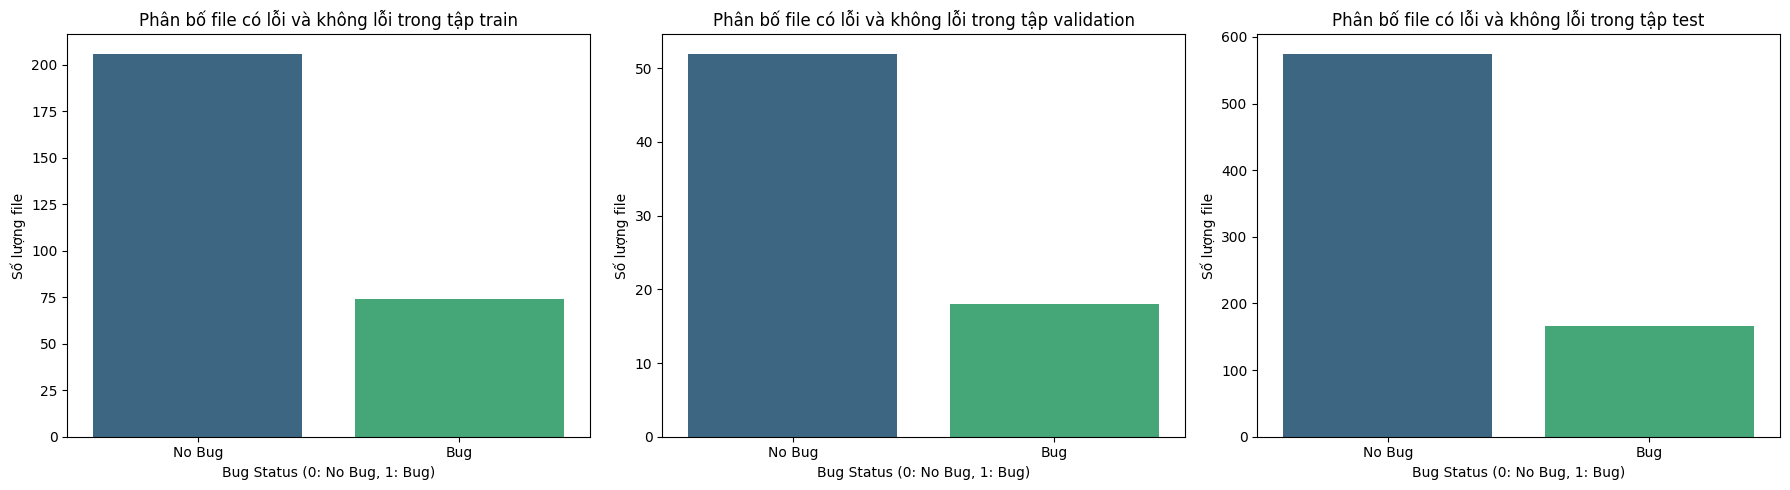

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kiểm tra số lượng mẫu trong từng lớp của từng tập (train, val, test)
train_bug_counts = train_df['bug'].value_counts()
val_bug_counts = val_df['bug'].value_counts()
test_bug_counts = test_df['bug'].value_counts()

# Vẽ biểu đồ cho tập train
plt.figure(figsize=(18, 5))

# Tập train
plt.subplot(1, 3, 1)
sns.barplot(x=train_bug_counts.index, y=train_bug_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập train")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Tập validation
plt.subplot(1, 3, 2)
sns.barplot(x=val_bug_counts.index, y=val_bug_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập validation")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Tập test
plt.subplot(1, 3, 3)
sns.barplot(x=test_bug_counts.index, y=test_bug_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập test")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()


Nhận thấy dữ liệu Bug đang mất cân bằng so với dữ liệu No bug, có thể xử lí bằng 1 số cách như SMOTE, xoá bớt dữ liệu trong No Bug,.. Theo bài báo, ở đây xử lí bằng cáchnhân đôi các instance từ lớp

### Xử lí mất cân bằng dữ liệu

In [ ]:
# Nhân đôi các mẫu của lớp bug=1 trong các tập dữ liệu train, validation, test

# Tập train
bug_class_train = train_df[train_df['bug'] == 1]
duplicated_bug_class_train = pd.concat([bug_class_train, bug_class_train])
balanced_train_df = pd.concat([train_df[train_df['bug'] == 0], duplicated_bug_class_train])
balanced_train_df = balanced_train_df.reset_index(drop=True)

# Tập validation
bug_class_val = val_df[val_df['bug'] == 1]
duplicated_bug_class_val = pd.concat([bug_class_val, bug_class_val])
balanced_val_df = pd.concat([val_df[val_df['bug'] == 0], duplicated_bug_class_val])
balanced_val_df = balanced_val_df.reset_index(drop=True)

# Tập test
bug_class_test = test_df[test_df['bug'] == 1]
duplicated_bug_class_test = pd.concat([bug_class_test, bug_class_test])
balanced_test_df = pd.concat([test_df[test_df['bug'] == 0], duplicated_bug_class_test])
balanced_test_df = balanced_test_df.reset_index(drop=True)

# Kiểm tra kết quả
print(f"Số lượng file trong tập train sau cân bằng:\n{balanced_train_df['bug'].value_counts()}")
print(f"Số lượng file trong tập validation sau cân bằng:\n{balanced_val_df['bug'].value_counts()}")
print(f"Số lượng file trong tập test sau cân bằng:\n{balanced_test_df['bug'].value_counts()}")


Số lượng file trong tập train sau cân bằng:
bug
0    206
1    148
Name: count, dtype: int64
Số lượng file trong tập validation sau cân bằng:
bug
0    52
1    36
Name: count, dtype: int64
Số lượng file trong tập test sau cân bằng:
bug
0    575
1    332
Name: count, dtype: int64


In [ ]:
# Lưu các tập dữ liệu đã được cân bằng
balanced_train_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_train_data.csv"
balanced_val_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_val_data.csv"
balanced_test_csv_path = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_test_data.csv"

balanced_train_df.to_csv(balanced_train_csv_path, index=False)
balanced_val_df.to_csv(balanced_val_csv_path, index=False)
balanced_test_df.to_csv(balanced_test_csv_path, index=False)

print(f"Dữ liệu train đã được cân bằng và lưu tại: {balanced_train_csv_path}")
print(f"Dữ liệu validation đã được cân bằng và lưu tại: {balanced_val_csv_path}")
print(f"Dữ liệu test đã được cân bằng và lưu tại: {balanced_test_csv_path}")

Dữ liệu train đã được cân bằng và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_train_data.csv
Dữ liệu validation đã được cân bằng và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_val_data.csv
Dữ liệu test đã được cân bằng và lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/balanced_test_data.csv


### Visualization lại dữ liệu sau khi xử lí

<ipython-input-23-ede4eba8d77c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_train_counts.index, y=balanced_train_counts.values, palette="viridis")
<ipython-input-23-ede4eba8d77c>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_val_counts.index, y=balanced_val_counts.values, palette="viridis")
<ipython-input-23-ede4eba8d77c>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balanced_test_counts.index, y=balanced_test_counts.values, palette="viridis")


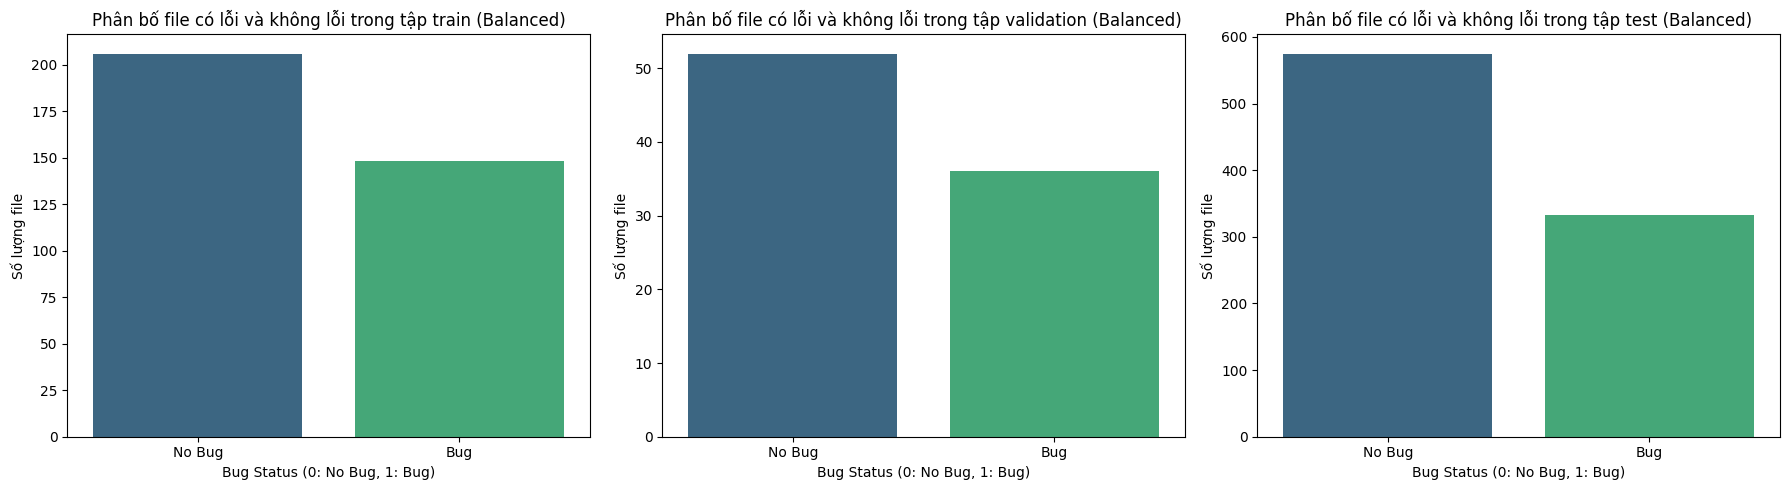

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kiểm tra số lượng mẫu trong từng lớp của từng tập (train, val, test) sau cân bằng
balanced_train_counts = balanced_train_df['bug'].value_counts()
balanced_val_counts = balanced_val_df['bug'].value_counts()
balanced_test_counts = balanced_test_df['bug'].value_counts()

# Vẽ biểu đồ cho tập balanced
plt.figure(figsize=(18, 5))

# Tập train balanced
plt.subplot(1, 3, 1)
sns.barplot(x=balanced_train_counts.index, y=balanced_train_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập train (Balanced)")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Tập validation balanced
plt.subplot(1, 3, 2)
sns.barplot(x=balanced_val_counts.index, y=balanced_val_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập validation (Balanced)")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Tập test balanced
plt.subplot(1, 3, 3)
sns.barplot(x=balanced_test_counts.index, y=balanced_test_counts.values, palette="viridis")
plt.xlabel("Bug Status (0: No Bug, 1: Bug)")
plt.ylabel("Số lượng file")
plt.title("Phân bố file có lỗi và không lỗi trong tập test (Balanced)")
plt.xticks(ticks=[0, 1], labels=["No Bug", "Bug"])

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


## Lọc ra các file mới chứa các source code trùng với file

### Tập train

In [ ]:
# Chuẩn hóa danh sách file bug=1 từ CSV để khớp với source code
bug_files_csv = set(train_df['name'].apply(convert_csv_name_to_java_filename))

# Chuẩn hóa danh sách file từ source code để có dạng giống CSV
source_files_formatted = set(convert_java_path_to_filename(f, train_dir) for f in filtered_train_files)

print(f"📌 Tổng số file trong CSV: {len(bug_files_csv)}")
print(f"📌 Tổng số file source code có trong thư mục: {len(source_files_formatted)}")

# Lọc ra các file trong train_dir có tên trùng với CSV
matched_files = bug_files_csv.intersection(source_files_formatted)

# Lọc danh sách file từ train_dir để chỉ giữ các file có trong matched_files
train_files_new = [f for f in filtered_train_files if convert_java_path_to_filename(f, train_dir) in matched_files]

train_new_df = pd.DataFrame({'name': train_files_new})
print(f"📌 Tổng số file source code có trong thư mục sau khi lọc: {len(train_files_new)}")





📌 Tổng số file trong CSV: 280
📌 Tổng số file source code có trong thư mục: 350
📌 Tổng số file source code có trong thư mục sau khi lọc: 280


### Tập validation

In [ ]:
# Chuẩn hóa danh sách file bug=1 từ CSV để khớp với source code
bug_files_csv = set(val_df['name'].apply(convert_csv_name_to_java_filename))

# Chuẩn hóa danh sách file từ source code để có dạng giống CSV
source_files_formatted = set(convert_java_path_to_filename(f, train_dir) for f in filtered_train_files)

print(f"📌 Tổng số file trong CSV: {len(bug_files_csv)}")
print(f"📌 Tổng số file source code có trong thư mục: {len(source_files_formatted)}")

# Lọc ra các file trong train_dir có tên trùng với CSV
matched_files = bug_files_csv.intersection(source_files_formatted)

# Lọc danh sách file từ train_dir để chỉ giữ các file có trong matched_files
val_dir_new = [f for f in filtered_train_files if convert_java_path_to_filename(f, train_dir) in matched_files]

# Lọc danh sách file từ train_dir để chỉ giữ các file có trong matched_files
val_files_new = [f for f in filtered_train_files if convert_java_path_to_filename(f, train_dir) in matched_files]

val_new_df= pd.DataFrame({'name': val_files_new})
print(f"📌 Tổng số file source code có trong thư mục sau khi lọc: {len(val_files_new)}")




📌 Tổng số file trong CSV: 70
📌 Tổng số file source code có trong thư mục: 350
📌 Tổng số file source code có trong thư mục sau khi lọc: 70


## Nhân đôi file dữ liệu trong source code

Để đảm bảo dữ liệu huấn luyện được đồng bộ giữa CSV và mã nguồn,` cần nhân đôi các file source code tương ứng với các file đã bị nhân đôi trong CSV.

### Tập train

In [ ]:
import shutil
# 🔹 Lọc danh sách file có bug=1 từ CSV
bug_train_csv = set(train_df[train_df['bug'] == 1]['name'].apply(convert_csv_name_to_java_filename))

# 🔹 Lọc danh sách file source code có bug=1
train_files_new_1 = [file for file in filtered_train_files if convert_java_path_to_filename(file, train_dir) in bug_train_csv]

print(f"📌 Tổng số file bug=1 trong CSV: {len(bug_train_csv)}")
print(f"📌 Tổng số file source code có bug=1: {len(train_files_new_1)}")

# 🔹 3. Nhân đôi file source code có bug=1 và cập nhật danh sách
duplicated_files = []
for file in train_files_new_1:
    duplicate_file_path = file.replace(".java", "_dup.java")  # Tạo tên file mới
    shutil.copy(file, duplicate_file_path)  # Sao chép file
    duplicated_files.append(duplicate_file_path)

# 🔹 4. Cập nhật danh sách filtered_train_files
train_files_new += duplicated_files  # Thêm file nhân đôi vào danh sách gốc

# 🔹 5. Kiểm tra lại số lượng file sau nhân đôi
print(f"📌 Số file source code gốc (train set): {len(train_files_new) - len(duplicated_files)}")
print(f"📌 Số file source code nhân đôi: {len(duplicated_files)}")
print(f"✅ Tổng số file source code sau nhân đôi: {len(train_files_new)}")

# 🔹 6. Hiển thị danh sách file đã nhân đôi
print("\n📜 Danh sách file đã nhân đôi:")
print(duplicated_files[:10])  # Hiển thị 10 file đầu tiên


📌 Tổng số file bug=1 trong CSV: 74
📌 Tổng số file source code có bug=1: 74
📌 Số file source code gốc (train set): 280
📌 Số file source code nhân đôi: 74
✅ Tổng số file source code sau nhân đôi: 354

📜 Danh sách file đã nhân đôi:
['apache-ant-1.6.0/src/main/org/apache/tools/zip/ZipOutputStream_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/zip/ZipEntry_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/zip/ZipFile_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/ProjectHelper_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/ComponentHelper_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Diagnostics_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/RuntimeConfigurable_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/ProjectComponent_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Target_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Project_dup.java']


### Tập validation

In [ ]:
import shutil

# 🔹 Lọc danh sách file có bug=1 từ CSV
bug_val_csv = set(val_df[val_df['bug'] == 1]['name'].apply(convert_csv_name_to_java_filename))

# 🔹 Lọc danh sách file source code có bug=1
val_files_new_1 = [file for file in val_files_new if convert_java_path_to_filename(file, train_dir) in bug_val_csv]

print(f"📌 Tổng số file bug=1 trong CSV: {len(bug_val_csv)}")
print(f"📌 Tổng số file source code có bug=1: {len(val_files_new_1)}")

# 🔹 3. Nhân đôi file source code có bug=1 và cập nhật danh sách
duplicated_files = []
for file in val_files_new_1:
    duplicate_file_path = file.replace(".java", "_dup.java")  # Tạo tên file mới
    shutil.copy(file, duplicate_file_path)  # Sao chép file
    duplicated_files.append(duplicate_file_path)

# 🔹 4. Cập nhật danh sách filtered_validation_files
val_files_new += duplicated_files  # Thêm file nhân đôi vào danh sách gốc

# 🔹 5. Kiểm tra lại số lượng file sau nhân đôi
print(f"📌 Số file source code gốc (validation set): {len(val_files_new) - len(duplicated_files)}")
print(f"📌 Số file source code nhân đôi: {len(duplicated_files)}")
print(f"✅ Tổng số file source code sau nhân đôi: {len(val_files_new)}")

# 🔹 6. Hiển thị danh sách file đã nhân đôi
print("\n📜 Danh sách file đã nhân đôi:")
print(duplicated_files[:10])  # Hiển thị 10 file đầu tiên


📌 Tổng số file bug=1 trong CSV: 18
📌 Tổng số file source code có bug=1: 18
📌 Số file source code gốc (validation set): 70
📌 Số file source code nhân đôi: 18
✅ Tổng số file source code sau nhân đôi: 88

📜 Danh sách file đã nhân đôi:
['apache-ant-1.6.0/src/main/org/apache/tools/ant/UnknownElement_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/Task_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/IntrospectionHelper_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/PropertyHelper_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/Definer_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/Replace_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/PumpStreamHandler_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/DependSet_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/MacroInstance_dup.java', 'apache-ant-1.6.0/src/main/org/apache/tools/ant/taskdefs/SQLExec_dup.java']


### Tập test

In [ ]:
import shutil

# 🔹 Lọc danh sách file có bug=1 từ CSV
bug_test_csv = set(test_df[test_df['bug'] == 1]['name'].apply(convert_csv_name_to_java_filename))

# 🔹 Lọc danh sách file source code có bug=1
test_files_new_1 = [file for file in filtered_test_files if convert_java_path_to_filename(file, test_dir) in bug_test_csv]

print(f"📌 Tổng số file bug=1 trong CSV: {len(bug_test_csv)}")
print(f"📌 Tổng số file source code có bug=1: {len(test_files_new_1)}")

# 🔹 3. Nhân đôi file source code có bug=1 và cập nhật danh sách
duplicated_files = []
for file in test_files_new_1:
    duplicate_file_path = file.replace(".java", "_dup.java")  # Tạo tên file mới
    shutil.copy(file, duplicate_file_path)  # Sao chép file
    duplicated_files.append(duplicate_file_path)

# 🔹 4. Cập nhật danh sách filtered_test_files
filtered_test_files += duplicated_files  # Thêm file nhân đôi vào danh sách gốc

# 🔹 5. Kiểm tra lại số lượng file sau nhân đôi
print(f"📌 Số file source code gốc (test set): {len(filtered_test_files) - len(duplicated_files)}")
print(f"📌 Số file source code nhân đôi: {len(duplicated_files)}")
print(f"✅ Tổng số file source code sau nhân đôi: {len(filtered_test_files)}")

# 🔹 6. Hiển thị danh sách file đã nhân đôi
print("\n📜 Danh sách file đã nhân đôi:")
print(duplicated_files[:10])  # Hiển thị 10 file đầu tiên


📌 Tổng số file bug=1 trong CSV: 166
📌 Tổng số file source code có bug=1: 166
📌 Số file source code gốc (test set): 741
📌 Số file source code nhân đôi: 166
✅ Tổng số file source code sau nhân đôi: 907

📜 Danh sách file đã nhân đôi:
['apache-ant-1.7.0/src/main/org/apache/tools/bzip2/CBZip2InputStream_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/bzip2/CBZip2OutputStream_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/UnrecognizedExtraField_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/AsiExtraField_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ZipShort_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ExtraFieldUtils_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ZipOutputStream_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ZipEntry_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ZipFile_dup.java', 'apache-ant-1.7.0/src/main/org/apache/tools/zip/ZipLong_dup.java']


# 2. Phân tích cây AST

In [ ]:
!pip install javalang


In [ ]:
import javalang

def extract_tokens_from_file(file_path):
    """Trích xuất các token quan trọng từ cây AST của mã nguồn Java"""
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            code = f.read()

        tokens = []
        tree = javalang.parse.parse(code)  # Phân tích mã nguồn thành AST

        for path, node in tree:
            if isinstance(node, javalang.tree.MethodInvocation):
                tokens.append(node.member)
            elif isinstance(node, javalang.tree.ClassDeclaration):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.ConstructorDeclaration):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.VariableDeclarator):
                tokens.append(node.name)
            elif isinstance(node, javalang.tree.MemberReference):
                tokens.append(node.member)
            elif isinstance(node, javalang.tree.IfStatement):
                tokens.append("<IF>")
            elif isinstance(node, javalang.tree.ForStatement):
                tokens.append("<FOR>")
            elif isinstance(node, javalang.tree.WhileStatement):
                tokens.append("<WHILE>")
            elif isinstance(node, javalang.tree.CatchClause):
                tokens.append("<CATCH>")

        return tokens
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        return []


In [ ]:
import javalang

def extract_tokens_from_file(file_path):
    """Trích xuất các token quan trọng từ cây AST của mã nguồn Java (cải tiến)."""
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            code = f.read()

        tokens = []
        tree = javalang.parse.parse(code)  # Phân tích mã nguồn thành AST

        for path, node in tree:
            # ✅ Trích xuất tên Method và Constructor với tiền tố 'METHOD_'
            if isinstance(node, javalang.tree.MethodDeclaration):
                tokens.append(f"METHOD_{node.name}")
            elif isinstance(node, javalang.tree.ConstructorDeclaration):
                tokens.append(f"METHOD_{node.name}")

            # ✅ Lấy danh sách tên Class/Interface với tiền tố 'CLASS_'
            elif isinstance(node, javalang.tree.ClassDeclaration) or isinstance(node, javalang.tree.InterfaceDeclaration):
                tokens.append(f"CLASS_{node.name}")

            # ✅ Lấy biến với tiền tố 'VAR_' để phân biệt
            elif isinstance(node, javalang.tree.VariableDeclarator):
                tokens.append(f"VAR_{node.name}")

            # ✅ Lấy các thành viên class
            elif isinstance(node, javalang.tree.MemberReference):
                tokens.append(f"MEMBER_{node.member}")

            # ✅ Thêm thông tin Annotation (nếu có)
            elif isinstance(node, javalang.tree.Annotation):
                tokens.append(f"ANNOTATION_{node.name}")

            # ✅ Lấy các từ khóa điều kiện & vòng lặp
            elif isinstance(node, javalang.tree.IfStatement):
                tokens.append("<IF>")
            elif isinstance(node, javalang.tree.ForStatement):
                tokens.append("<FOR>")
            elif isinstance(node, javalang.tree.WhileStatement):
                tokens.append("<WHILE>")
            elif isinstance(node, javalang.tree.DoStatement):
                tokens.append("<DO>")
            elif isinstance(node, javalang.tree.SwitchStatement):
                tokens.append("<SWITCH>")
            elif hasattr(javalang.tree, "CaseStatement") and isinstance(node, javalang.tree.CaseStatement):
                tokens.append("<CASE>")  # ✅ Chỉ thêm nếu `CaseStatement` tồn tại
            elif isinstance(node, javalang.tree.TryStatement):
                tokens.append("<TRY>")
            elif isinstance(node, javalang.tree.ThrowStatement):
                tokens.append("<THROW>")
            elif isinstance(node, javalang.tree.CatchClause):
                tokens.append("<CATCH>")
            elif isinstance(node, javalang.tree.ReturnStatement):
                tokens.append("<RETURN>")

            # ✅ Lấy thông tin kiểu dữ liệu biến
            elif isinstance(node, javalang.tree.LocalVariableDeclaration):
                for var in node.declarators:
                    tokens.append(f"VAR_{var.name}_TYPE_{node.type.name}")

            # ✅ Lấy kiểu dữ liệu tham số của hàm
            elif isinstance(node, javalang.tree.MethodDeclaration):
                for param in node.parameters:
                    tokens.append(f"PARAM_{param.name}_TYPE_{param.type.name}")

            # ✅ Lấy tên các import để hiểu bối cảnh code
            elif isinstance(node, javalang.tree.Import):
                tokens.append(f"IMPORT_{node.path}")

        return tokens
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")
        return []


In [ ]:
sample_file = filtered_train_files[9]  # Lấy một file từ danh sách đã lọc
sample_tokens = extract_tokens_from_file(sample_file)
print("📌 Token từ file mẫu:", sample_tokens)


📌 Token từ file mẫu: ['IMPORT_java.util.Hashtable', 'IMPORT_java.util.Vector', 'IMPORT_java.util.zip.ZipException', 'CLASS_ExtraFieldUtils', 'VAR_implementations', 'MEMBER_implementations', 'METHOD_register', '<TRY>', 'VAR_ze_TYPE_ZipExtraField', 'VAR_ze', 'MEMBER_c', '<CATCH>', '<THROW>', 'MEMBER_c', '<CATCH>', '<THROW>', 'MEMBER_c', '<CATCH>', '<THROW>', 'MEMBER_c', 'METHOD_createExtraField', 'VAR_c_TYPE_Class', 'VAR_c', 'MEMBER_headerId', '<IF>', 'MEMBER_c', '<RETURN>', 'VAR_u_TYPE_UnrecognizedExtraField', 'VAR_u', 'MEMBER_headerId', '<RETURN>', 'MEMBER_u', 'METHOD_parse', 'VAR_v_TYPE_Vector', 'VAR_v', 'VAR_start_TYPE_int', 'VAR_start', '<WHILE>', 'MEMBER_start', 'MEMBER_length', 'VAR_headerId_TYPE_ZipShort', 'VAR_headerId', 'MEMBER_data', 'MEMBER_start', 'VAR_length_TYPE_int', 'VAR_length', 'MEMBER_data', 'MEMBER_start', '<IF>', 'MEMBER_start', 'MEMBER_length', 'MEMBER_length', '<THROW>', 'MEMBER_start', '<TRY>', 'VAR_ze_TYPE_ZipExtraField', 'VAR_ze', 'MEMBER_headerId', 'MEMBER_dat

In [ ]:
# Trích xuất token từ tất cả các file trong tập train và test
train_tokens = {file: extract_tokens_from_file(file) for file in train_files_new}
test_tokens = {file: extract_tokens_from_file(file) for file in filtered_test_files}
val_tokens = {file: extract_tokens_from_file(file) for file in val_files_new}
# Kiểm tra kết quả
print(f"Số file đã trích xuất token (train): {len(train_tokens)}")
print(f"Số file đã trích xuất token (validation): {len(val_tokens)}")
print(f"Số file đã trích xuất token (test): {len(test_tokens)}")

# Xem một file mẫu
sample_file = filtered_train_files[0]
print("📌 Token từ file:", sample_file)
print(train_tokens[sample_file])


Số file đã trích xuất token (train): 354
Số file đã trích xuất token (validation): 88
Số file đã trích xuất token (test): 907
📌 Token từ file: apache-ant-1.6.0/src/main/org/apache/tools/bzip2/CRC.java
['CLASS_CRC', 'VAR_crc32Table', 'METHOD_CRC', 'METHOD_initialiseCRC', 'MEMBER_globalCrc', 'METHOD_getFinalCRC', '<RETURN>', 'MEMBER_globalCrc', 'METHOD_getGlobalCRC', '<RETURN>', 'MEMBER_globalCrc', 'METHOD_setGlobalCRC', 'MEMBER_globalCrc', 'MEMBER_newCrc', 'METHOD_updateCRC', 'VAR_temp_TYPE_int', 'VAR_temp', 'MEMBER_globalCrc', 'MEMBER_inCh', '<IF>', 'MEMBER_temp', 'MEMBER_temp', 'MEMBER_temp', 'MEMBER_globalCrc', 'MEMBER_globalCrc', 'MEMBER_crc32Table', 'MEMBER_temp', 'VAR_globalCrc']


In [ ]:
from google.colab import drive
import pickle
import os

# 🔹 1. Mount Google Drive
drive.mount('/content/drive')

# 🔹 2. Định nghĩa đường dẫn lưu file
save_dir = "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/"
save_path = os.path.join(save_dir, "dp_cnn_tokens.pkl")

# 🔹 3. Tạo thư mục nếu chưa tồn tại
os.makedirs(save_dir, exist_ok=True)

# 🔹 4. Lưu file vào thư mục trong Google Drive
data = {
    "train_tokens": train_tokens,
    "test_tokens": test_tokens,
    "val_tokens": val_tokens
}

with open(save_path, "wb") as f:
    pickle.dump(data, f)

print(f"✅ File đã được lưu tại: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File đã được lưu tại: /content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/dp_cnn_tokens.pkl


# 3. Word embedding

- Làm bên folder khác: https://drive.google.com/file/d/13aXuvPECb4fUPLQEEVwSRNUCZQBukSur/view?usp=sharing
- Token sau khi embedding được lưu vào trong file dp_cnn_embeddings.pkl có link: "/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/dp_cnn_embeddings.pkl"

In [ ]:
import pickle
import numpy as np
from google.colab import drive
import os

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Task DP-CNN/dp_cnn_embeddings.pkl'


# Mở và đọc dữ liệu từ file .pkl
with open(file_path, 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train_embeddings']
X_test = data['X_test_embeddings']
X_val = data['X_val_embeddings']

print(f"📌 Dữ liệu train shape: {X_train.shape}")
print(f"📌 Dữ liệu validation shape: {X_val.shape}")
print(f"📌 Dữ liệu test shape: {X_test.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📌 Dữ liệu train shape: (354, 100, 30)
📌 Dữ liệu validation shape: (88, 100, 30)
📌 Dữ liệu test shape: (907, 100, 30)


Kiểm tra lại nhãn

In [ ]:
import numpy as np

# Chuyển nhãn thành NumPy array
y_train = np.array(balanced_train_df['bug'].values)  # 0 hoặc 1
y_val = np.array(balanced_val_df['bug'].values)  # 0 hoặc 1
y_test = np.array(balanced_test_df['bug'].values)  # 0 hoặc 1

print(f"📌 Nhãn train shape: {y_train.shape}")
print(f"📌 Nhãn val shape: {y_val.shape}")
print(f"📌 Nhãn test shape: {y_test.shape}")


📌 Nhãn train shape: (354,)
📌 Nhãn val shape: (88,)
📌 Nhãn test shape: (907,)


# 4. Huấn luyện mạng CNN

- Huấn luyện CNN để trích xuất đặc trưng từ mã nguồn thông qua các vector word embedding (dạng chuỗi token).
- Lấy các đặc trưng truyền thống từ file CSV
- Ghép nối đặc trưng CNN và đặc trưng truyền thống để tổng hợp thông tin.
- Dự đoán lỗi phần mềm bằng lớp Logistic Regression (lớp Dense cuối cùng với sigmoid).

##Trích xuất các cột số từ CSV làm đầu vào bổ sung

In [ ]:
X_train_traditional = np.array(balanced_train_df.iloc[:, 1:-1].values)  # Bỏ cột đầu tiên (name) và cuối cùng (bug)
X_test_traditional = np.array(balanced_test_df.iloc[:, 1:-1].values)
X_val_traditional = np.array(balanced_val_df.iloc[:, 1:-1].values)

print(f"📌 Traditional Features - Train shape: {X_train_traditional.shape}")
print(f"📌 Traditional Features - Validation shape: {X_val_traditional.shape}")
print(f"📌 Traditional Features - Test shape: {X_test_traditional.shape}")

print(X_train_traditional[1])

📌 Traditional Features - Train shape: (354, 20)
📌 Traditional Features - Validation shape: (88, 20)
📌 Traditional Features - Test shape: (907, 20)
[  3.           4.           0.           4.          21.
   3.           0.           4.           1.           1.5
 144.           1.           0.           0.96078431   1.
   2.           3.          46.66666667   9.           3.3333    ]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_traditional = scaler.fit_transform(X_train_traditional)
X_val_traditional = scaler.transform(X_val_traditional)
X_test_traditional = scaler.transform(X_test_traditional)


In [ ]:
## Định nghĩa cấu trúc mạng nơ ron và huấn luyện

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Định nghĩa siêu tham số tối ưu
FILTERS = 250
KERNEL_SIZE = 5
DENSE_UNITS = 100
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.001
NUM_TRADITIONAL_FEATURES = X_train_traditional.shape[1]  # Số đặc trưng truyền thống
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 30

# Input từ CNN
input_layer_cnn = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))  # (None, 100, 30)

# Các lớp Conv1D và MaxPooling
conv_layer_1 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(input_layer_cnn)
batch_norm_1 = BatchNormalization()(conv_layer_1)  # Batch Normalization
conv_layer_2 = Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')(batch_norm_1)
batch_norm_2 = BatchNormalization()(conv_layer_2)  # Batch Normalization
pool_layer = GlobalMaxPooling1D()(batch_norm_2)

# Thêm lớp Dense và Dropout
dense_layer = Dense(DENSE_UNITS, activation='relu')(pool_layer)
dropout_layer = Dropout(DROPOUT_RATE)(dense_layer)

# Lấy Traditional Features và concatenate với đầu ra của mạng CNN
input_layer_traditional = Input(shape=(NUM_TRADITIONAL_FEATURES,))
merged_features = Concatenate()([dropout_layer, input_layer_traditional])

# Đưa qua lớp dense
dense_2_layer = Dense(DENSE_UNITS, activation='relu', kernel_regularizer=l2(0.01))(merged_features)

# Lớp Logistic Regression (Dự đoán lỗi phần mềm)
output_layer = Dense(1, activation='sigmoid')(dense_2_layer)

# Tạo mô hình tổng hợp
model = Model(inputs=[input_layer_cnn, input_layer_traditional], outputs=output_layer)

# Compile mô hình với learning rate thấp hơn
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Sử dụng ReduceLROnPlateau callback để điều chỉnh learning rate khi cần thiết
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

# Hiển thị kiến trúc mô hình
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 100, 30)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 96, 250)        │         37,750 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 96, 250)        │          1,000 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 92, 250)        │        312,750 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 92, 250)        │          1,000 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 250)            │              0 │ batch_normalization_9… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 100)            │         25,100 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 100)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 120)            │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 100)            │         12,100 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1)              │            101 │ dense_13[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 389,801 (1.49 MB)

 Trainable params: 388,801 (1.48 MB)

 Non-trainable params: 1,000 (3.91 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

# 🔹 Số epochs để huấn luyện
epochs = 50
history_dict = {}

# 🔹 Tạo callback để in kết quả sau mỗi epoch
class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Dự đoán trên tập test ngay sau epoch hiện tại
        y_pred = (self.model.predict([X_test, X_test_traditional]) > 0.5).astype("int32")

        # Tính Classification Report đúng cách
        report = classification_report(y_test, y_pred, output_dict=True)

        # Lưu lịch sử từng epoch
        history_dict[epoch + 1] = {
            "accuracy": logs["accuracy"],
            "val_accuracy": logs["val_accuracy"],
            "loss": logs["loss"],
            "val_loss": logs["val_loss"],
            "precision": report["1"]["precision"] if "1" in report else 0,
            "recall": report["1"]["recall"] if "1" in report else 0,
            "f1-score": report["1"]["f1-score"] if "1" in report else 0
        }

        # 🔥 In kết quả sau mỗi epoch
        print(f"\n📌 Epoch {epoch + 1}/{epochs} - "
              f"Accuracy: {logs['accuracy']:.4f}, "
              f"Loss: {logs['loss']:.4f}, "
              f"Val Accuracy: {logs['val_accuracy']:.4f}, "
              f"Val Loss: {logs['val_loss']:.4f}, "
              f"Precision: {history_dict[epoch + 1]['precision']:.4f}, "
              f"Recall: {history_dict[epoch + 1]['recall']:.4f}, "
              f"F1-score: {history_dict[epoch + 1]['f1-score']:.4f}")

# 🔹 Huấn luyện mô hình với callback tùy chỉnh
history = model.fit(
    [X_train, X_train_traditional], y_train,
    validation_data=([X_val, X_val_traditional], y_val),
    epochs=epochs, batch_size=16, verbose=0,
    callbacks=[MetricsCallback()]
)

# 🔹 In toàn bộ lịch sử sau khi huấn luyện xong
print("\n📊 History Dict:")
print(history_dict)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

📌 Epoch 1/50 - Accuracy: 0.6271, Loss: 1.7598, Val Accuracy: 0.6136, Val Loss: 1.5423, Precision: 0.5043, Recall: 0.8735, F1-score: 0.6395
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📌 Epoch 2/50 - Accuracy: 0.7147, Loss: 1.4171, Val Accuracy: 0.7500, Val Loss: 1.3284, Precision: 0.6295, Recall: 0.7319, F1-score: 0.6769
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📌 Epoch 3/50 - Accuracy: 0.7740, Loss: 1.2015, Val Accuracy: 0.6364, Val Loss: 1.2746, Precision: 0.5691, Recall: 0.8313, F1-score: 0.6756
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📌 Epoch 4/50 - Accuracy: 0.7740, Loss: 1.0690, Val Accuracy: 0.7727, Val Loss: 1.1343, Precision: 0.6621, Recall: 0.7259, F1-score: 0.6925
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step

📌 Epoch 5/50 - Accuracy: 0.8107, Loss: 0.9582, Val Accuracy: 0.6932, Val Loss: 1.0909, Precision: 0.6018, Recall: 0.8012, F1-score: 0.6873
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

📌 Epoch 6/50 - Accuracy: 0.8107, Loss: 0.8821, Val Accuracy

In [ ]:
y_pred_prob = model.predict([X_test, X_test_traditional])
print(y_pred_prob[:30])  # In 10 giá trị dự đoán ban đầu để kiểm tra


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
[[4.47535396e-01]
 [4.22003359e-04]
 [2.33637495e-03]
 [8.79514124e-03]
 [2.30921502e-03]
 [2.02339783e-04]
 [3.95052619e-02]
 [1.33987173e-01]
 [1.18977083e-02]
 [5.87612055e-02]
 [9.24624875e-03]
 [2.60802984e-01]
 [4.64778859e-03]
 [9.75051597e-02]
 [3.49695273e-02]
 [8.60595226e-01]
 [1.00821845e-01]
 [4.21297125e-04]
 [4.13611357e-04]
 [3.45850140e-01]
 [3.61304381e-04]
 [7.57820904e-03]
 [9.40192025e-03]
 [7.89124548e-01]
 [7.90842436e-03]
 [1.76042169e-02]
 [3.13983679e-01]
 [1.89266115e-01]
 [2.45448355e-05]
 [3.58410507e-01]]


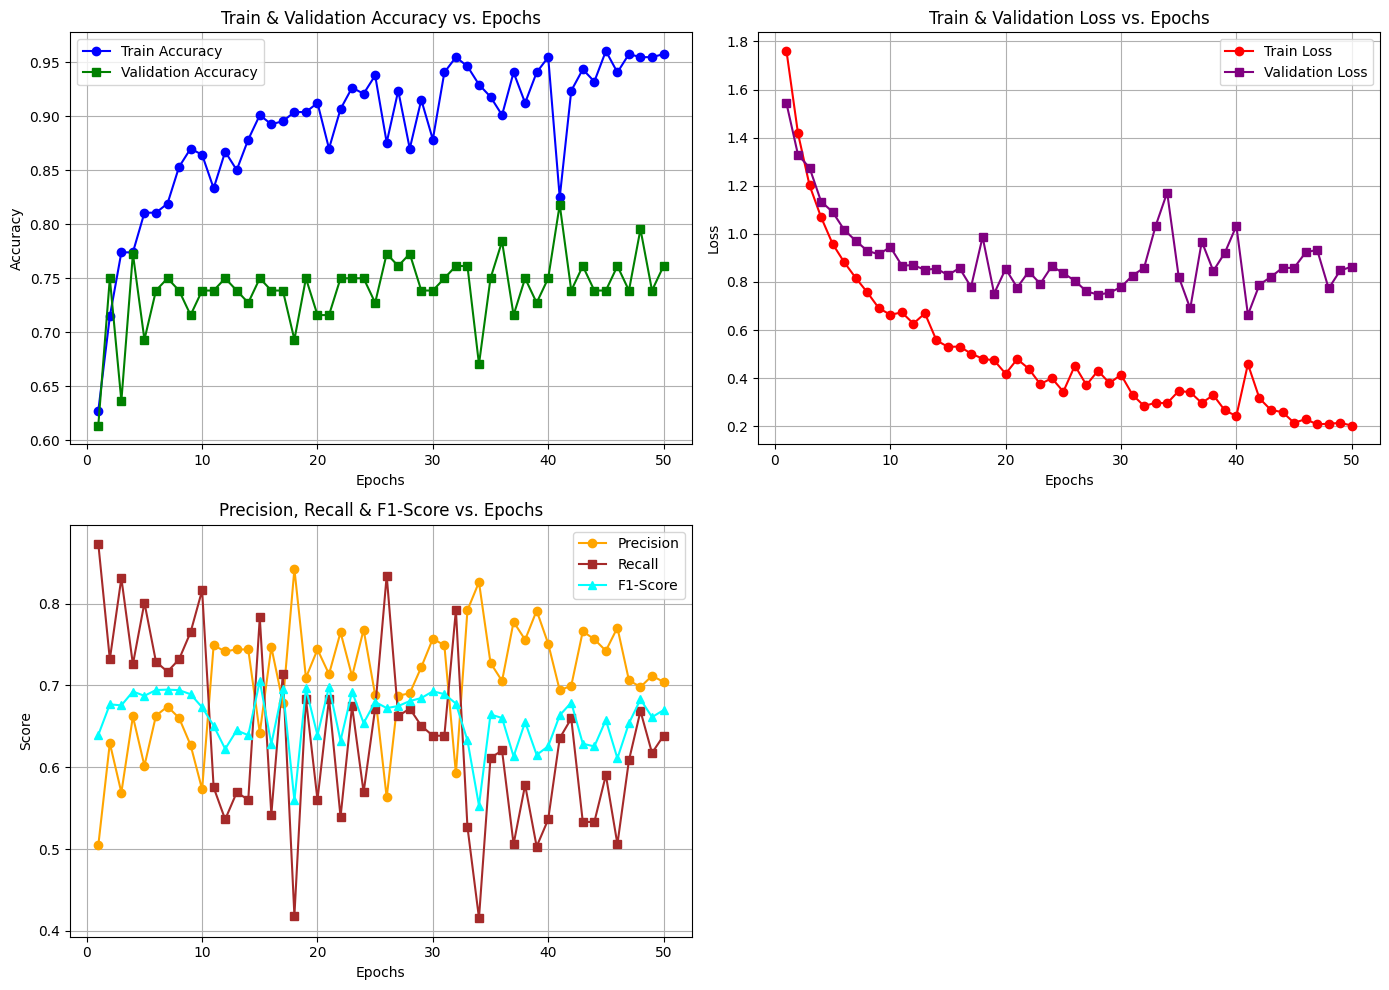

In [ ]:
import matplotlib.pyplot as plt

# Kiểm tra và trích xuất dữ liệu từ history_dict
epochs_values = list(history_dict.keys())

train_acc = [history_dict[ep].get("accuracy", None) for ep in epochs_values]
val_acc = [history_dict[ep].get("val_accuracy", None) for ep in epochs_values]
train_loss = [history_dict[ep].get("loss", None) for ep in epochs_values]
val_loss = [history_dict[ep].get("val_loss", None) for ep in epochs_values]
precision = [history_dict[ep].get("precision", None) for ep in epochs_values]
recall = [history_dict[ep].get("recall", None) for ep in epochs_values]
f1_score = [history_dict[ep].get("f1-score", None) for ep in epochs_values]

# Tạo biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 🔹 1. Vẽ biểu đồ Accuracy
axes[0, 0].plot(epochs_values, train_acc, marker='o', label="Train Accuracy", color='b')
axes[0, 0].plot(epochs_values, val_acc, marker='s', label="Validation Accuracy", color='g')
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_title("Train & Validation Accuracy vs. Epochs")
axes[0, 0].legend()
axes[0, 0].grid()

# 🔹 2. Vẽ biểu đồ Loss
axes[0, 1].plot(epochs_values, train_loss, marker='o', label="Train Loss", color='r')
axes[0, 1].plot(epochs_values, val_loss, marker='s', label="Validation Loss", color='purple')
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].set_title("Train & Validation Loss vs. Epochs")
axes[0, 1].legend()
axes[0, 1].grid()

# 🔹 3. Vẽ biểu đồ Precision, Recall, F1-score
axes[1, 0].plot(epochs_values, precision, marker='o', label="Precision", color='orange')
axes[1, 0].plot(epochs_values, recall, marker='s', label="Recall", color='brown')
axes[1, 0].plot(epochs_values, f1_score, marker='^', label="F1-Score", color='cyan')
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_title("Precision, Recall & F1-Score vs. Epochs")
axes[1, 0].legend()
axes[1, 0].grid()

# Ẩn ô trống (nếu có)
axes[1, 1].axis("off")

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 🔹 1. Thêm Early Stopping để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🔹 2. Huấn luyện mô hình với batch size nhỏ hơn để tăng khả năng generalization
model.fit(
    [X_train, X_train_traditional], y_train,
    validation_data=([X_val, X_val_traditional], y_val),
    epochs=epochs, batch_size=16, verbose=0,
    callbacks=[MetricsCallback()]
)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step

📌 Epoch 1/50 - Accuracy: 0.9576, Loss: 0.1859, Val Accuracy: 0.7614, Val Loss: 0.8322, Precision: 0.7148, Recall: 0.5964, F1-score: 0.6502
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step

📌 Epoch 2/50 - Accuracy: 0.9689, Loss: 0.1970, Val Accuracy: 0.7500, Val Loss: 0.8337, Precision: 0.7184, Recall: 0.5994, F1-score: 0.6535
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

📌 Epoch 3/50 - Accuracy: 0.9576, Loss: 0.1877, Val Accuracy: 0.7614, Val Loss: 0.8462, Precision: 0.7046, Recall: 0.6898, F1-score: 0.6971
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

📌 Epoch 4/50 - Accuracy: 0.9520, Loss: 0.1863, Val Accuracy: 0.7955, Val Loss: 0.9413, Precision: 0.6354, Recall: 0.7560, F1-score: 0.6905
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

📌 Epoch 5/50 - Accuracy: 0.9661, Loss: 0.1946, Val Accuracy: 0.7386, Val Loss: 0.8455, Precision: 0.7128, Recall: 0.6205, F1-score: 0.6634
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

📌 Epoch 6/50 - Accuracy: 0.9746, Loss: 0.1680, Val Accuracy

In [ ]:
from sklearn.metrics import classification_report

# 🔹 1. Dự đoán trên tập test
y_pred = (model.predict([X_test, X_test_traditional]) > 0.5).astype("int32")

# 🔹 2. In báo cáo kết quả
print(classification_report(y_test, y_pred))


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       575
           1       0.73      0.59      0.65       332

    accuracy                           0.77       907
   macro avg       0.76      0.73      0.74       907
weighted avg       0.77      0.77      0.76       907



# Đánh giá mô hình

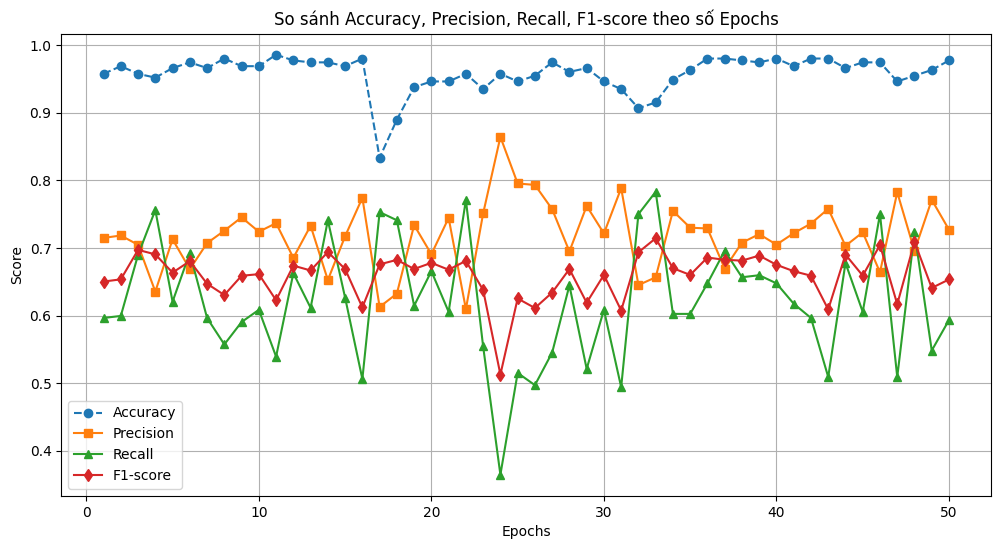

In [ ]:
import matplotlib.pyplot as plt

# Trích xuất dữ liệu từ history_dict
epochs_values = list(history_dict.keys())
accuracy = [history_dict[ep]["accuracy"] for ep in epochs_values]
precision = [history_dict[ep]["precision"] for ep in epochs_values]
recall = [history_dict[ep]["recall"] for ep in epochs_values]
f1_score = [history_dict[ep]["f1-score"] for ep in epochs_values]

# 🔹 Vẽ biểu đồ
plt.figure(figsize=(12, 6))

plt.plot(epochs_values, accuracy, marker='o', linestyle='--', label="Accuracy")
plt.plot(epochs_values, precision, marker='s', label="Precision")
plt.plot(epochs_values, recall, marker='^', label="Recall")
plt.plot(epochs_values, f1_score, marker='d', label="F1-score")

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("So sánh Accuracy, Precision, Recall, F1-score theo số Epochs")
plt.legend()
plt.grid()

plt.show()


# Làm theo bài báo phần Embedding